**K-Means Clustering**



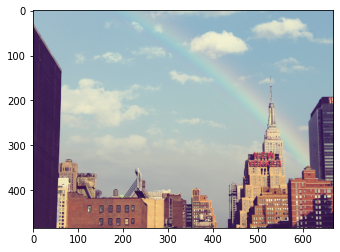

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('/content/building.png')

# Change color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

In [ ]:
pixel_vals = image.reshape((-1,3))

# Convert to float type
pixel_vals = np.float32(pixel_vals)

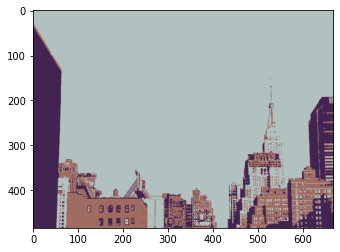

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

plt.imshow(segmented_image)

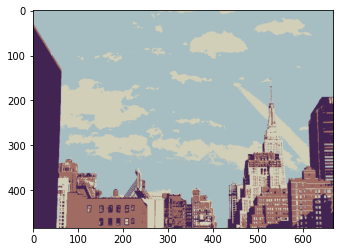

In [ ]:
criteria2 = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 4
retval2, labels_2, centers_2 = cv2.kmeans(pixel_vals, k, None, criteria2, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert data into 8-bit values
centers_2 = np.uint8(centers_2)
segmented_data2 = centers_2[labels_2.flatten()]

# reshape data into the original image dimensions
segmented_image2 = segmented_data2.reshape((image.shape))

plt.imshow(segmented_image2)

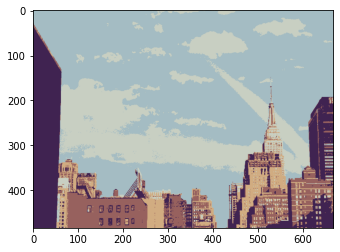

In [ ]:
criteria3 = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 5
retval3, labels_3, centers_3 = cv2.kmeans(pixel_vals, k, None, criteria3, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert data into 8-bit values
centers_3 = np.uint8(centers_3)
segmented_data3 = centers_3[labels_3.flatten()]

# reshape data into the original image dimensions
segmented_image3 = segmented_data3.reshape((image.shape))

plt.imshow(segmented_image3)

**SLIC**

In [ ]:
from skimage.data import astronaut
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.util import img_as_float

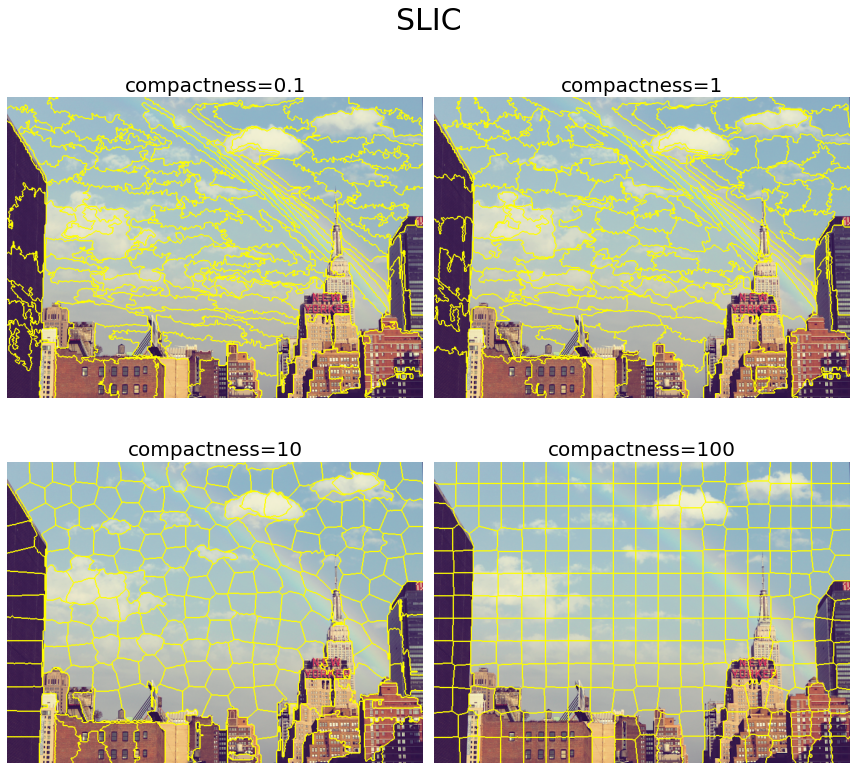

In [ ]:
def plot_image(img, title):
    plt.imshow(img)
    plt.title(title, size=20)
    plt.axis('off')

img = img_as_float(image)
plt.figure(figsize=(12,12))
i = 1
for compactness in [0.1, 1, 10, 100]:
    plt.subplot(2,2,i)
    segments_slic = slic(img, n_segments=250, compactness=compactness, sigma=1,start_label=1)
    plot_image(mark_boundaries(img, segments_slic), 'compactness=' + str(compactness))
    i += 1
plt.suptitle('SLIC', size=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Second SLIC Implementation**

In [ ]:
import math
from skimage import io, color
from skimage.transform import resize
import numpy as np

In [ ]:
def make_superPixel(h, w,img):
    return SuperPixels(h, w,img[h,w][0],img[h,w][1],img[h,w][2])

In [ ]:
def initial_cluster_center(S,img,img_h,img_w,clusters):
    h = S // 2
    w = S // 2
    while h < img_h:
        while w < img_w:
            clusters.append(make_superPixel(h, w,img))
            w += S
        w = S // 2
        h += S
    return clusters

In [ ]:
def calc_gradient(h, w,img,img_w,img_h):
    if w + 1 >= img_w:
        w = img_w - 2
    if h + 1 >= img_h:
        h = img_h - 2
    grad = img[w + 1, h + 1][0] - img[w, h][0] + img[w + 1, h + 1][1] - img[w, h][1] + img[w + 1, h + 1][2] - img[w, h][2]
    return grad

In [ ]:
def reassign_cluster_center_acc_to_grad(clusters,img):
    for c in clusters:
        cluster_gradient = calc_gradient(c.h, c.w,img,img_w,img_h)
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                H = c.h + dh
                W = c.w + dw
                new_gradient = calc_gradient(H,W, img,img_w,img_h)
                if new_gradient < cluster_gradient:
                    c.update(H, W,img[H,W][0], img[H,W][1],img[H,W][2])
                    c_gradient = new_gradient

In [ ]:
'''
function to assign pixels to the nearest cluster using the Euclidean distance involving both color and spatial
proximity.
'''
def assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis):
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):
            if h < 0 or h >= img_h: continue
            for w in range(c.w - 2 * S, c.w + 2 * S):
                if w < 0 or w >= img_w: continue
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds /S, 2))
                if D < dis[h,w]:
                    if (h, w) not in tag:
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        tag[(h, w)].pixels.remove((h, w))
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D

In [ ]:
# function to replace the cluster center with the mean of the pixels contained in the cluster
def update_cluster_mean(clusters):
    for c in clusters:
        sum_h = sum_w = number = 0
        #print("c.pixels",c.pixels)
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
            H = sum_h // number
            W = sum_w // number
            c.update(H, W,img[H, W][0], img[H, W][1], img[H, W][2])

In [ ]:
# replace the color of each pixel in a cluster by the color of the cluster's center
def avg_color_cluster(img,name,clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        # To change the color of cluster center to Black
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    lab2rgb(name, image)

In [ ]:
# function for the Simple Linear Iterative Clustering
def slic(S,img,img_h,img_w,clusters,tag,dis):
    clusters = initial_cluster_center(S,img,img_h,img_w,clusters)
    reassign_cluster_center_acc_to_grad(clusters,img)
    for i in range(10): # usually the algortihm converges within 10 iterations
        assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis)
        update_cluster_mean(clusters)
        if i == 9 : # to print the output after 10 iterations
            name = 'out_m{m}_k{k}.png'.format(loop=i, m=m, k=k)
            avg_color_cluster(img,name, clusters)
    return clusters

In [ ]:

# function to convert LAB images back to RGB and save it
def lab2rgb(path, lab_arr):
    rgb_arr = color.lab2rgb(lab_arr)
    io.imsave(path, rgb_arr)

In [ ]:
# A class to initialize the super pixels, of the form - [h,y,l,a,b].
class SuperPixels(object):

    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)
        self.pixels = []

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

In [ ]:
rgb = io.imread("/content/building.png",plugin='matplotlib')
print(rgb.shape)

# input images are resized to (400 x 400) for processing
img = resize(rgb, (400,400),anti_aliasing=True)
print(img.shape)

# convert RGB to LAB
img = color.rgb2lab(img)

k = 128   # Number of Super pixels
m = 20    # Constant for normalizing the color proximity, range of m = [1,40]

img_h = img.shape[0] # Image Height
img_w = img.shape[1] # Image Width

N = img_h * img_w  # Total number of pixels in the image
S = int(math.sqrt(N /k)) # average size of each superpixel

clusters = []
tag = {}
# initialize the distance between pixels and cluster center as infinity
dis = np.full((img_h, img_w), np.inf)

(484, 668, 3)
(400, 400, 3)


In [ ]:
cluster = slic(S,img,img_h,img_w,clusters,tag,dis)

In [ ]:
rgb1 = io.imread("/content/building.png",plugin='matplotlib')
print(rgb1.shape)

# input images are resized to (400 x 400) for processing
img1 = resize(rgb1, (400,400),anti_aliasing=True)
print(img1.shape)

# convert RGB to LAB
img1 = color.rgb2lab(img1)

k1 = 256   # Number of Super pixels
m1 = 20    # Constant for normalizing the color proximity, range of m = [1,40]

img_h1 = img1.shape[0] # Image Height
img_w1 = img1.shape[1] # Image Width

N1 = img_h1 * img_w1  # Total number of pixels in the image
S1 = int(math.sqrt(N1 /k1)) # average size of each superpixel

clusters1 = []
tag1 = {}
# initialize the distance between pixels and cluster center as infinity
dis1 = np.full((img_h1, img_w1), np.inf)

(484, 668, 3)
(400, 400, 3)


In [ ]:
cluster1 = slic(S1,img1,img_h1,img_w1,clusters1,tag1,dis1)

In [ ]:
rgb2 = io.imread("/content/building.png",plugin='matplotlib')
print(rgb2.shape)

# input images are resized to (400 x 400) for processing
img2 = resize(rgb2, (400,400),anti_aliasing=True)
print(img2.shape)

# convert RGB to LAB
img2 = color.rgb2lab(img2)

k2 = 64   # Number of Super pixels
m2 = 30    # Constant for normalizing the color proximity, range of m = [1,40]

img_h2 = img2.shape[0] # Image Height
img_w2 = img2.shape[1] # Image Width

N2 = img_h2 * img_w2  # Total number of pixels in the image
S2 = int(math.sqrt(N2 /k2)) # average size of each superpixel

clusters2 = []
tag2 = {}
# initialize the distance between pixels and cluster center as infinity
dis2 = np.full((img_h2, img_w2), np.inf)

(484, 668, 3)
(400, 400, 3)


In [ ]:
cluster2 = slic(S2,img2,img_h2,img_w2,clusters2,tag2,dis2)

In [ ]:
rgb3 = io.imread("/content/building.png",plugin='matplotlib')
print(rgb3.shape)

# input images are resized to (400 x 400) for processing
img3 = resize(rgb3, (400,400),anti_aliasing=True)
print(img3.shape)

# convert RGB to LAB
img3 = color.rgb2lab(img3)

k3 = 400   # Number of Super pixels
m3 = 30    # Constant for normalizing the color proximity, range of m = [1,40]

img_h3 = img3.shape[0] # Image Height
img_w3 = img3.shape[1] # Image Width

N3 = img_h3 * img_w3  # Total number of pixels in the image
S3 = int(math.sqrt(N3 /k3)) # average size of each superpixel

clusters3 = []
tag3 = {}
# initialize the distance between pixels and cluster center as infinity
dis3 = np.full((img_h3, img_w3), np.inf)

(484, 668, 3)
(400, 400, 3)


In [ ]:
cluster3 = slic(S3,img3,img_h3,img_w3,clusters3,tag3,dis3)